<a href="https://colab.research.google.com/github/tkmaroon/use-cases-of-bert/blob/master/unsupervised_lexical_simplification_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Lexical Simplification with BERT
## Overview
Lexical simplification aims to replace complex words in a given sentence with their simpler alternatives whlie preserve meaning.  This notebook performs lexical simplification with BERT following "*A Simple BERT-Based Approach for Lexical Simplification*" [1]. The proposed method is a very simple, but effective.   



## Settings

In [0]:
#@title Setup environment
!pip install --quiet pytorch-transformers
!pip install --quiet pytorch-nlp
!pip install --quiet tqdm

In [0]:
#@title Setup common imports
import random
import math
from collections import Counter
from tqdm import tqdm

import numpy as np
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

#from torchnlp.datasets import smt_dataset

from pytorch_transformers import (
    BertConfig,
    BertTokenizer,
    BertForMaskedLM,
    BertForTokenClassification,
    AdamW,
    WarmupLinearSchedule,
)

import matplotlib.pyplot as plt
% matplotlib inline

## Substitution Generation
We obtain substitution candidate...
<!-- Figure: The model architechture -->



In [0]:
# Build model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [0]:
# Model's input
text = "[CLS] the cat perched on the mat [SEP] the cat perched on the mat [SEP]"
masked_idx = 10

In [0]:
# Tokenize a text
tokenized_text = tokenizer.tokenize(text)

# Mask a complex token which should be substituted
complex_word = tokenized_text[masked_idx]
tokenized_text[masked_idx] = '[MASK]'

# Convert inputs to PyTorch tensors
tokens_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
tokens_tensor = torch.tensor([tokens_ids])
segments_tensors = torch.tensor([segments_ids])

In [0]:
# Predict a masked token
model.eval()
if torch.cuda.is_available():
    tokens_tensor = tokens_tensor.to('cuda')
    segments_tensors = segments_tensors.to('cuda')
    model.to('cuda')

with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

Input: [CLS] the cat perched on the mat [SEP] the cat [MASK] on the mat [SEP]
Top10: ['perched', 'sat', 'landed', 'was', 'rested', 'stood', 'settled', 'hovered', 'sitting', 'crouched']


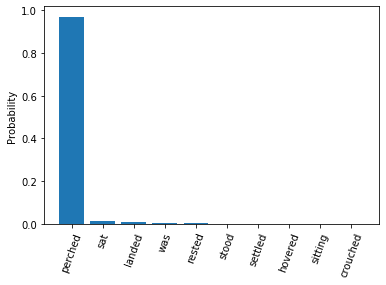

In [10]:
# Output top 10 of candidates
topk_score, topk_index = torch.topk(predictions[0, masked_idx], 10)
topk_tokens = tokenizer.convert_ids_to_tokens(topk_index.tolist())
print(f'Input: {" ".join(tokenized_text)}')
print(f'Top10: {topk_tokens}')

# Visualize output probabilities
plt.bar(topk_tokens, torch.softmax(topk_score, 0).tolist())
plt.xticks(rotation=70)
plt.ylabel('Probability')
plt.show()

## Substitution Ranking
Previous section, we obtained subsitution candidates of a complex word "*perched*".  
In this section, we rank substitution candidates by following four features:

- Probability of BERT prediction;
- Probability of n-gram language model;
- Similarity obtained by FastText;
- Word frequency;

We choose the top of candidate with the highest average rank over all features as the simplification replacement.

In this notebook, we use only a **probabitity of BERT predicaiton** and a **word frequency** for ranking step.

In [0]:
#@title Download the Children's Book Test (CBT)
!wget http://www.thespermwhale.com/jaseweston/babi/CBTest.tgz
!tar -xzf ./CBTest.tgz
!DATA_PATH=./CBTest/data; cat ${DATA_PATH}/cbt_train.txt ${DATA_PATH}/cbt_valid.txt ${DATA_PATH}/cbt_test.txt > ./cbt_all.txt
!wc ./cbt_all.txt

In [41]:
#@title Build a table of word frequency
def count_lines(path):
  with open(path, 'r') as f:
    return sum([1 for _ in f])

word_frequency = Counter()
filepath = './cbt_all.txt'
n_lines = count_lines(filepath)
with open(filepath, 'r') as f:
  for line in tqdm(f, total=n_lines):
    if line.startswith("_BOOK_TITLE_"):
      continue
    else:
      tokens = tokenizer.tokenize(line.rstrip())
      for token in tokens:
        word_frequency[token] += 1

100%|██████████| 292912/292912 [02:03<00:00, 2362.40it/s]


In [0]:
# substitution ranking
bert_rank = np.array([i for i in range(len(topk_tokens))])
frequency_rank = np.argsort([-word_frequency[token] for token in topk_tokens])
avg_rank = np.argsort((bert_rank + frequency_rank) / 2)

# sort candidates and except a complex word
candidates = [topk_tokens[i] for i in avg_rank if topk_tokens[i] != complex_word]

In [79]:
tokenized_text[masked_idx] = candidates[0]
print(" ".join(tokenized_text))

[CLS] the cat perched on the mat [SEP] the cat sat on the mat [SEP]


## References

[1] [A Simple BERT-Based Approach for Lexical Simplification
](https://arxiv.org/abs/1907.06226)  
[2] [huggingface/transformers](https://github.com/huggingface/transformers)
